In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from __future__ import annotations

import os

import pyproj
import xarray as xr
import pyresample.kd_tree
import numpy as np
import pyresample.kd_tree

from mesoscaler.core import Payload
from mesoscaler.core import Mesoscale, make_independent, P0, IndependentDataset, DependentDataset
from mesoscaler.enums import (
    # - dependent variables
    URMA,
    ERA5,
    # - independent variables
    Dimensions,
    Coordinates,
    X,
    Y,
    Z,
    T,
    LAT,
    LON,
    LVL,
    TIME,
    COORDINATES,
    DIMENSIONS,
)

_test_data = "../tests/data"

urma_store = os.path.join(_test_data, "urma.zarr")
urma_dvars = list(URMA)

era5_store = os.path.join(_test_data, "era5.zarr")
era5_dvars = list(ERA5)

print(era5_dvars, urma_dvars, sep="\n")

[geopotential, specific_humidity, temperature, u_component_of_wind, v_component_of_wind, vertical_velocity]
[total_cloud_cover, ceiling, u_wind_component_10m, v_wind_component_10m, wind_speed_10m, wind_speed_gust, wind_direction_10m, temperature_2m, dewpoint_temperature_2m, specific_humidity_2m, surface_pressure, visibility, orography]


In [3]:
_URMA_DATASET = xr.open_zarr(urma_store)
_URMA_DATASET

<xarray.Dataset>
Dimensions:                  (time: 2, y: 1597, x: 2345)
Coordinates:
  * time                     (time) datetime64[ns] 2019-01-02 2019-01-02T01:0...
Dimensions without coordinates: y, x
Data variables: (12/14)
    ceiling                  (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    dewpoint_temperature_2m  (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    latitude                 (y, x) float64 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    longitude                (y, x) float64 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    specific_humidity_2m     (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    surface_pressure         (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    ...                       ...
    u_wind_component_10m     (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    v_wind_component_10m     (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    visibility               (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    wind_direction_10m       (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    wind_speed_10m           (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    wind_speed_gust          (time, y, x) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
Attributes:
    area_definition:  None

In [4]:
if not os.path.exists(era5_store):
    _google_store = "gs://weatherbench2/datasets/era5/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2"
    xr.open_zarr(_google_store)[era5_dvars].sel(time=_URMA_DATASET.time).to_zarr(era5_store, mode="w")

_ERA5_DATASET = xr.open_zarr(era5_store)
_ERA5_DATASET

<xarray.Dataset>
Dimensions:              (time: 2, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude             (latitude) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * level                (level) int64 1 2 3 5 7 10 ... 875 900 925 950 975 1000
  * longitude            (longitude) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time                 (time) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
Data variables:
    geopotential         (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    specific_humidity    (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    temperature          (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    u_component_of_wind  (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind  (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity    (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>

In [5]:
def get_urma() -> xr.Dataset:
    return make_independent(_URMA_DATASET.copy())


def get_era5() -> xr.Dataset:
    return make_independent(_ERA5_DATASET.copy())


urma = get_urma()
urma

<xarray.Dataset>
Dimensions:                  (T: 2, Z: 1, Y: 1597, X: 2345)
Coordinates:
    latitude                 (Y, X) float64 19.23 19.23 19.24 ... 54.38 54.37
    longitude                (Y, X) float64 233.7 233.7 233.8 ... 300.9 301.0
  * time                     (T) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
  * vertical                 (Z) float64 1.013e+03
Dimensions without coordinates: T, Z, Y, X
Data variables:
    ceiling                  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    dewpoint_temperature_2m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    specific_humidity_2m     (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    surface_pressure         (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    temperature_2m           (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    total_cloud_cover        (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    u_wind_component_10m     (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    v_wind_component_10m     (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    visibility               (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    wind_direction_10m       (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    wind_speed_10m           (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    wind_speed_gust          (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
Attributes:
    area_definition:  None
    grid_definition:  Shape: (1597, 2345)\nLons: [[-126.276552   -126.2531205...

In [6]:
era5 = get_era5()
era5

<xarray.Dataset>
Dimensions:              (T: 2, Z: 37, Y: 721, X: 1440)
Coordinates:
    latitude             (Y, X) float32 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * vertical             (Z) int64 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
    longitude            (Y, X) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time                 (T) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
Dimensions without coordinates: T, Z, Y, X
Data variables:
    geopotential         (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    specific_humidity    (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    temperature          (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    u_component_of_wind  (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind  (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity    (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
Attributes:
    grid_definition:  Shape: (721, 1440)\nLons: [[ 0.    0.25  0.5  ... -0.75...

In [7]:
ds = DependentDataset.from_zarr(urma_store, [URMA.CEIL, URMA.VIS])
print(ds.crs.is_geocentric, ds.crs.is_geographic, ds.crs.is_projected)
ds = DependentDataset.from_zarr(era5_store, [ERA5.T])
print(ds.crs.is_geocentric, ds.crs.is_geographic, ds.crs.is_projected)

False False True
False True False


In [8]:
urma = DependentDataset.from_zarr(urma_store, [URMA.CEIL, URMA.VIS])
era5 = DependentDataset.from_zarr(era5_store, ERA5(["temperature"]))
era5

<xarray.Dataset>
Dimensions:      (T: 2, Z: 37, Y: 721, X: 1440)
Coordinates:
    latitude     (Y, X) float32 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
  * vertical     (Z) int64 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
    longitude    (Y, X) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time         (T) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
Dimensions without coordinates: T, Z, Y, X
Data variables:
    temperature  (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
Attributes:
    grid_definition:  Shape: (721, 1440)\nLons: [[ 0.    0.25  0.5  ... -0.75...

In [9]:
scale = Mesoscale(200, 200, pressure=[P0, 1000.0, 925.0, 850.0, 700.0, 500.0, 300.0], rate=20)
scale

Mesoscale:
  scale: '[ 1.00  4.74  9.69 12.23 15.26 17.70 19.37]'
    hpa: '[1013.25 1000.00  925.00  850.00  700.00  500.00  300.00]'
     dx: '[ 200.00  948.93 1938.97 2446.80 3051.46 3539.82 3874.94]'
     dy: '[ 200.00  948.93 1938.97 2446.80 3051.46 3539.82 3874.94]'

(721, 1440)
(72, 144, 2)


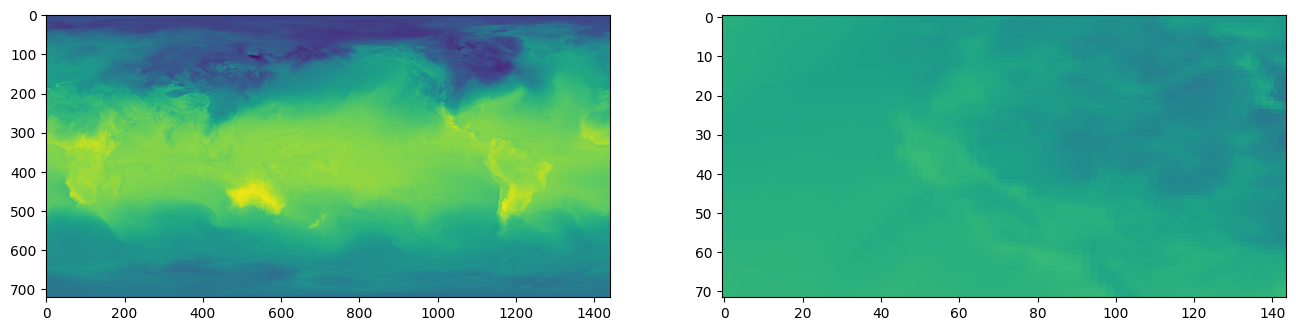

In [10]:
CHANNELS = "channels"
VARIABLE = "variable"


p = scale.resample(urma, era5).payloads[1]


#  721X: 1440
def resample_on_center(self: Payload):
    target = pyresample.geometry.AreaDefinition(
        "",
        "",
        "",
        projection=pyproj.CRS.from_cf(
            {
                "grid_mapping_name": "lambert_azimuthal_equal_area",
                "latitude_of_projection_origin": 40,
                "longitude_of_projection_origin": -120,
            }
        ),
        width=1440 // 10,
        height=721 // 10,
        area_extent=self.area_extent * 1000,
    )
    da = self.ds.transpose(Y, X, ...).to_array("V").stack({"C": ["V", T, Z]})
    return pyresample.kd_tree.resample_nearest(
        self.grid_definition,
        data=da.to_numpy(),
        target_geo_def=target,
        radius_of_influence=500000,
    )


import matplotlib.pyplot as plt

N = 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8 * N, 2 * N))
t = p.ds.isel({T: 0, Z: 0})["temperature"]
vmin = t.to_numpy().min()
vmax = t.to_numpy().max()
ax1.imshow(t)
# t.plot.imshow(ax=ax2, origin="upper")
print(t.shape)
img = resample_on_center(p)
print(img.shape)
ax2.imshow(img[:, :, 0], vmin=vmin, vmax=vmax)

In [11]:
# import functools


# class ReSampler:
#     def __init__(
#         self,
#         width=80,
#         height=80,
#         *,
#         ids: IndependentDataset,
#     ) -> None:
#         md = ids.metadata
#         self._source_definition = pyresample.geometry.AreaDefinition(
#             area_id=f"{md.title} Area Definition",
#             description=md.comment,
#             proj_id=md.crs.name,
#             projection=md.crs,
#             height=ids.y.size,
#             width=ids.y.size,
#             area_extent=ids.area_extent,
#             # lons=lons,
#             # lats=lats,
#         )

#         self._target_definition = functools.partial(
#             pyresample.geometry.AreaDefinition,
#             area_id="lambert_azimuthal_equal_area",
#             description="lambert_azimuthal_equal_area",
#             proj_id="lambert_azimuthal_equal_area",
#             width=width,
#             height=height,
#         )

#     def get_target_definition(
#         self, latitude: float, longitude: float, area_extent: list[float]
#     ) -> pyresample.geometry.AreaDefinition:
#         crs = pyproj.CRS.from_cf(
#             {
#                 "grid_mapping_name": "lambert_azimuthal_equal_area",
#                 "latitude_of_projection_origin": latitude,
#                 "longitude_of_projection_origin": longitude,
#                 "units": "m",
#             }
#         )

#         return self._target_definition(projection=crs, area_extent=area_extent)


# def get_grid_definition(self: IndependentDataset) -> pyresample.geometry.GridDefinition:
#     lons = self.lons.to_numpy()
#     if is_greenwich(ds.lons.to_numpy()):
#         lons = (lons - 180) % 360 - 180

#     return pyresample.geometry.GridDefinition(lons, self.lats)


# ds = IndependentDataset.from_zarr(urma_store, URMAEnum("t2m", "d2m"))
# lons = (ds.lons.to_numpy() - 180) % 360 - 180

# from src.mesoformer.typing import Boolean


# def is_greenwich(lons: np.ndarray) -> Boolean:
#     x = lons - (lons - 180) % 180
#     return np.all(x == 180.0)


# # print(
# #     ds.lons.to_numpy(),
# #     is_greenwich(ds.lons.to_numpy()),
# #     is_greenwich(360),
# #     # ds.lons.to_numpy(),
# #     # # ds.lons.to_numpy()[0],
# #     # lons,
# #     # np.unique(lons - (lons - 180) % 360 - 180),
# #     sep="\n==\n",
# #     # ds.lats.shape,
# # )
# # # get_grid_definition(IndependentDataset.from_zarr(urma_store, URMAEnum("t2m", "d2m")))


# # print(
# #     f"""\
# # {is_greenwich(0)=}
# # {is_greenwich(180)=}
# # {is_greenwich(360)=}
# # {is_greenwich(40)=}
# # """
# # )
# def is_geodetic(crs: pyproj.CRS) -> Boolean:
#     return crs.is_geographic


# print(
#     "\n=========\n".join(
#         f"""
# {crs.name=}
# area_of_use:\n{crs.area_of_use or 'undefined'}
# {is_geodetic(crs)=}
# """
#         for crs in (ERA5Enum.crs, URMAEnum.crs)
#     )
# )

In [12]:
# from src.mesoformer.typing import StrPath, Sequence, DictStrAny, Mapping, Hashable, Iterable
# from src.mesoformer.datasets.metadata import MetadataMixin
# from src.mesoformer.datasets.metadata import T, Z, X, Y, LON, LAT, LVL, TIME, DatasetMetadata
# import functools

# VariableLike = type[CFDatasetEnum] | CFDatasetEnum | Sequence[CFDatasetEnum]


# class PartialAreaDefinitions:
#     def __init__(
#         self,
#         width=256,
#         height=256,
#         *,
#         metadata: DatasetMetadata,
#         latitude: float = 25.0,
#         longitude: float = 265.0,
#     ) -> None:
#         self._source = None

#         self._target = functools.partial(
#             pyresample.geometry.AreaDefinition,
#             area_id="lambert_azimuthal_equal_area",
#             description="lambert_azimuthal_equal_area",
#             proj_id="lambert_azimuthal_equal_area",
#             projection=pyproj.CRS.from_cf(
#                 {
#                     "grid_mapping_name": "lambert_azimuthal_equal_area",
#                     "latitude_of_projection_origin": latitude,
#                     "longitude_of_projection_origin": longitude,
#                 }
#             ),
#             width=width,
#             height=height,
#         )

#     def __repr__(self) -> str:
#         return f"{self.__class__.__name__}({self._target})"

#     def __call__(self, area_extent: list[float]):
#         tgt = self._target(area_extent=area_extent)
#         return tgt, tgt

#     def iter_definitions(
#         self, area_extents: Iterable[list[float]]
#     ) -> Iterable[tuple[pyresample.geometry.AreaDefinition, pyresample.geometry.AreaDefinition]]:
#         for area_extent in area_extents:
#             yield self(area_extent)


# area_defs = PartialAreaDefinitions(
#     80,
#     80,
#     metadata=DatasetMetadata.from_title("ERA5"),
#     latitude=25.0,
#     longitude=265.0,
# )


# for src, tgt in area_defs.iter_definitions(extents):
#     print(src, tgt)

In [13]:
# class ReSampler:
#     def __init__(
#         self,
#         area_defs: PartialAreaDefinitions,
#     ) -> None:
#         pass

In [14]:
# class MesoDataset(IndependentDataset):
#     cf = types.MappingProxyType(
#         {
#             "geographic_crs_name": "NDFD CONUS 2.5km Lambert Conformal Conic",
#             "projected_crs_name": "NDFD",
#             "semi_major_axis": 6378137.0,
#             "semi_minor_axis": 6356752.31424518,
#             "inverse_flattening": 298.25722356301,
#             "reference_ellipsoid_name": "WGS 84",
#             "longitude_of_prime_meridian": 0.0,
#             "prime_meridian_name": "Greenwich",
#             "horizontal_datum_name": "WGS84",
#             "latitude_of_projection_origin": 20.191999,
#             "longitude_of_projection_origin": 238.445999,
#             "false_easting": 0.0,
#             "false_northing": 0.0,
#         }
#     )

#     def __init__(self, ds: xr.Dataset, dvars: VariableLike) -> None:
#         super().__init__(ds, dvars)

#     #     lons, lats = self.lons.to_numpy(), self.lats.to_numpy()
#     #     area_extent = [lons.min(), lats.min(), lons.max(), lats.max()]
#     #     self._source_definition = pyresample.geometry.AreaDefinition(
#     #         self.cf["geographic_crs_name"],
#     #         "National Digital Forecast Database Grid",
#     #         self.cf["projected_crs_name"],
#     #         self.get_crs("lambert_conformal_conic", standard_parallel=25),
#     #         self.x.size,
#     #         self.y.size,
#     #         area_extent=area_extent,
#     #         lons=lons,
#     #         lats=lats,
#     #     )

#     # def get_source_definition(self) -> pyresample.geometry.AreaDefinition:
#     #     return self._source_definition

#     # def get_target_definition(
#     #     self, latitude: float, longitude: float, width: float, height: float, area_extent: list[float]
#     # ) -> pyresample.geometry.AreaDefinition:
#     #     crs = self.get_crs("lambert_azimuthal_equal_area", latitude=latitude, longitude=longitude)
#     #     return pyresample.geometry.AreaDefinition(
#     #         "target_projection",
#     #         "description",
#     #         None,
#     #         crs,
#     #         width=width,
#     #         height=height,
#     #         area_extent=area_extent,
#     #     )

#     # def get_crs(
#     #     self, grid_mapping_name: str, *, latitude: float | None = None, longitude: float | None = None, **kwargs
#     # ) -> pyproj.CRS:
#     #     origin: dict[str, Any] = {"grid_mapping_name": grid_mapping_name, "units": "m"}
#     #     if latitude is not None:
#     #         origin["latitude_of_projection_origin"] = latitude

#     #     if longitude is not None:
#     #         origin["longitude_of_projection_origin"] = longitude

#     #     return pyproj.CRS.from_cf(self.cf | origin | kwargs)

#     # # @property
#     # # def area_extent(self) -> list[float]:
#     # #     return [
#     # #         self.lons.min(),
#     # #         self.lats.min(),
#     # #         self.lons.max(),
# #     # #         self.lats.max(),
# #     # #     ]
#     def _resample_on_center(self, target: pyresample.geometry.AreaDefinition) -> np.ndarray:
#         return pyresample.kd_tree.resample_nearest(self.area_definition, self.to_numpy(), target, radius_of_influence=50000)

#     # def resample_on_center(
#     #     self,
#     #     longitude: float,
#     #     latitude: float,
#     #     *,
#     #     width=256,
#     #     height=256,
#     #     dx=100,
#     #     dy=100,
#     #     scale_x=1,
#     #     scale_y=1,
#     #     units="km",
#     # ):
#     #     if units == "km":
#     #         dx *= 1000
#     #         dy *= 1000

#     #     dx /= 2
#     #     dy /= 2

#     #     height *= scale_y
#     #     width *= scale_x

#     #     source = self.get_source_definition()
#     #     data = self.da.to_numpy()

#     #     area_extent = [-dx * scale_x, -dy * scale_y, dx * scale_x, dy * scale_y]
#     #     target = self.get_target_definition(latitude, longitude, width, height, area_extent)

#     #     return pyresample.kd_tree.resample_nearest(source, data, target, radius_of_influence=50000)


# cf = MesoDataset.from_zarr(urma_store, URMAEnum("ceiling", "vis"))
# cf

In [15]:
# ceil = cf.dvars[0]
# print(ceil)
# ceil.crs

In [16]:
# import matplotlib.pyplot as plt


# class Dataset:
#     """
#     # CONUS and Northern Hemisphere Grids

#     https://graphical.weather.gov/docs/ndfdSRS.htm#:~:text=The%20NDFD%20uses%20the%20World%20Geodetic%20System,1984%20%28WGS84%29%20ellipsoid%20for%20its%20horizontal%20datum.

#     Grid Parameter	    CONUS 2.5km
#     Number of Points	2953665
#     Projection Type	    Lambert Conformal
#     Shape of Earth      Sphere
#     Earth Radius	    6371.2 km
#     Number of Points on the parallel	2145
#     Number of Points on the Meridian	1377
#     Latitude1:	20.191999
#     Longitude1:	238.445999
#     u/v vectors relative to:	easterly/northerly
#     Dx	2539.703 m
#     Dy	2539.703 m
#     GRIB2 grid, scan mode	64 (0100)
#     Scan i/x direction	positive
#     Scan j/y direction	positive
#     Consecutive points in	i/x direction
#     Adjacent rows scan in	same direction
#     Mesh Latitude	25
#     Orientation Longitude	265
#     Which Pole is on the Plane	north
#     Is Projection Bi-polar	no
#     Tangent Latitude1	25
#     Tangent Latitude2	25
#     Southern Latitude	-90
#     Southern Longitude	0
#     """

#     cf = types.MappingProxyType(
#         {
#             "geographic_crs_name": "NDFD CONUS 2.5km Lambert Conformal Conic",
#             "projected_crs_name": "NDFD",
#             "semi_major_axis": 6378137.0,
#             "semi_minor_axis": 6356752.31424518,
#             "inverse_flattening": 298.25722356301,
#             "reference_ellipsoid_name": "WGS 84",
#             "longitude_of_prime_meridian": 0.0,
#             "prime_meridian_name": "Greenwich",
#             "horizontal_datum_name": "WGS84",
#             "latitude_of_projection_origin": 20.191999,
#             "longitude_of_projection_origin": 238.445999,
#             "false_easting": 0.0,
#             "false_northing": 0.0,
#         }
#     )

#     def __init__(self, ds: xr.Dataset):
#         self.da = da = ds.to_array().transpose(X, Y, ...)
#         self.lons = lons = (da["longitude"].to_numpy() + 180) % 360 - 180
#         self.lats = lats = da["latitude"].to_numpy()

#         self._source_definition = pyresample.geometry.AreaDefinition(
#             self.cf["geographic_crs_name"],
#             "National Digital Forecast Database Grid",
#             self.cf["projected_crs_name"],
#             self.get_crs("lambert_conformal_conic", standard_parallel=25),
#             da[Y].size,
#             da[X].size,
#             area_extent=self.area_extent,
#             lons=lons,
#             lats=lats,
#         )

#     def get_source_definition(self) -> pyresample.geometry.AreaDefinition:
#         return self._source_definition

#     def get_target_definition(
#         self, latitude: float, longitude: float, width: float, height: float, area_extent: list[float]
#     ) -> pyresample.geometry.AreaDefinition:
#         crs = self.get_crs("lambert_azimuthal_equal_area", latitude=latitude, longitude=longitude)
#         return pyresample.geometry.AreaDefinition(
#             "target_projection",
#             "description",
#             None,
#             crs,
#             width=width,
#             height=height,
#             area_extent=area_extent,
#         )

#     def get_crs(
#         self, grid_mapping_name: str, *, latitude: float | None = None, longitude: float | None = None, **kwargs
#     ) -> pyproj.CRS:
#         origin: dict[str, Any] = {"grid_mapping_name": grid_mapping_name, "units": "m"}
#         if latitude is not None:
#             origin["latitude_of_projection_origin"] = latitude

#         if longitude is not None:
#             origin["longitude_of_projection_origin"] = longitude

#         return pyproj.CRS.from_cf(self.cf | origin | kwargs)

#     @property
#     def area_extent(self) -> list[float]:
#         return [
#             self.lons.min(),
#             self.lats.min(),
#             self.lons.max(),
#             self.lats.max(),
#         ]

#     def resample_on_center(
#         self,
#         longitude: float,
#         latitude: float,
#         *,
#         width=256,
#         height=256,
#         dx=100,
#         dy=100,
#         scale_x=1,
#         scale_y=1,
#         units="km",
#     ):
#         if units == "km":
#             dx *= 1000
#             dy *= 1000

#         dx /= 2
#         dy /= 2

#         height *= scale_y
#         width *= scale_x

#         source = self.get_source_definition()
#         data = self.da.to_numpy()

#         area_extent = [-dx * scale_x, -dy * scale_y, dx * scale_x, dy * scale_y]
#         target = self.get_target_definition(latitude, longitude, width, height, area_extent)

#         return pyresample.kd_tree.resample_nearest(source, data, target, radius_of_influence=50000)


# dataset = Dataset(get_era5().isel(T=0, Z=0))
# data = dataset.resample_on_center(longitude=-89.835, latitude=38.54)
# H, W, C = data.shape

# fig, axes = plt.subplots(1, C, figsize=(20, 5))

# for i in range(C):
#     ax = axes[i]
#     ax.imshow(data[:, :, i], origin="upper", cmap="terrain")
#     ax.set_xticks([])
#     ax.set_yticks([])